In [22]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import load_iris
import pandas as pd
import numpy  as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import networkx as nx
%matplotlib inline
!pip3 install netgraph
from netgraph import Graph
!pip install fdeb
from fdeb import fdeb
import matplotlib.collections as collections
import math
from sklearn.decomposition import PCA

In [23]:
from sklearn import datasets

iris = datasets.load_iris()

In [24]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [25]:
X = iris['data']
y = iris['target']
y_labels = iris['target_names']

In [26]:
import pandas as pd
X = pd.DataFrame(X, columns=iris['feature_names'])


In [27]:
#This cell gets the input and output names for the first and last layer
input_names = enumerate(iris["feature_names"])
ind_input_names = {}

for i, name in input_names:
  ind_input_names[i] = name.split()[0] + ' ' + name.split()[1]

target_names = enumerate(iris["target_names"])

ind_output_names = {}

for i, name in target_names:
  ind_output_names[i] = name
ind_output_names

{0: 'setosa', 1: 'versicolor', 2: 'virginica'}

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
# tf.random.set_seed(42)
input_shape = (4,)  # Replace input_shape with your actual input shape
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=4,),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=100, batch_size=1, verbose=1)

loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Test accuracy: {accuracy:.4f}')


Epoch 1/100
120/120 [==============================] - 2s 5ms/step - loss: 1.3337 - accuracy: 0.3750
Epoch 2/100
120/120 [==============================] - 1s 7ms/step - loss: 1.1243 - accuracy: 0.3833
Epoch 3/100
120/120 [==============================] - 1s 9ms/step - loss: 0.9961 - accuracy: 0.5083
Epoch 4/100
120/120 [==============================] - 1s 11ms/step - loss: 0.9170 - accuracy: 0.5750
Epoch 5/100
120/120 [==============================] - 1s 9ms/step - loss: 0.8642 - accuracy: 0.6333
Epoch 6/100
120/120 [==============================] - 1s 7ms/step - loss: 0.8274 - accuracy: 0.6667
Epoch 7/100
120/120 [==============================] - 1s 8ms/step - loss: 0.7980 - accuracy: 0.6833
Epoch 8/100
120/120 [==============================] - 1s 6ms/step - loss: 0.7725 - accuracy: 0.7500
Epoch 9/100
120/120 [==============================] - 1s 5ms/step - loss: 0.7455 - accuracy: 0.8083
Epoch 10/100
120/120 [==============================] - 1s 5ms/step - loss: 0.7211 - accur

### Arbitrarily ordered Graph

In [30]:
# Assuming you have Ws defined earlier, and Ws[-1] contains W1 and W2
# Define the weight matrices (taken from Ws[-1])
weights = model.weights
# Create a directed graph
G = nx.DiGraph()

pos = {}

i = 0
z = 0
maxRows = 0
for z in range(len(weights)):
  maxRows = max(maxRows, weights[z].shape[0])
  z += 2

maxRows += 1

colSize = [] #put in to allow for edge_label placement

col = 0
while i < len(weights):
  w = weights[i] #w are weights associated between two layers
  for sourceRow in range(w.shape[0]):

    if col == 0: # makes the first layer of nodes' names input the variables
      # rows and columns are kept in the name to help with determining pos
      source_node = ind_input_names[sourceRow] + '_' + str(sourceRow) + '_' + str(col)
    else: #Used for every layer but the first
      source_node = 'l_' + str(sourceRow) + '_' + str(col)

    # w.shape[0] is the length of the source column
    pos[source_node] = (col, maxRows/(w.shape[0] + 1) * (sourceRow + 1) * -5) # zero div prevented
    colSize.append(w.shape[1])  #puts size of dest column in the list, helps with edge label positioning

    for row in range(w.shape[1]):
      if (col + 1) == len(weights)//2: # if we are at the last layer, node names are made to be the output
        dest_node = ind_output_names[row] + '_' + str(row) + '_' + str(col + 1)
      else:
        dest_node = 'l_' + str(row) + '_' + str(col+1)

      G.add_edge(source_node, dest_node, weight = w[sourceRow][row])
      # w.shape[1] is length of the destination column
      pos[dest_node] = (col + 1, maxRows/(w.shape[1] + 1) * (row + 1) * -5)  #zero div prevented

  i += 2 # necessary to increment by 2 when using tensor flow
  col += 1

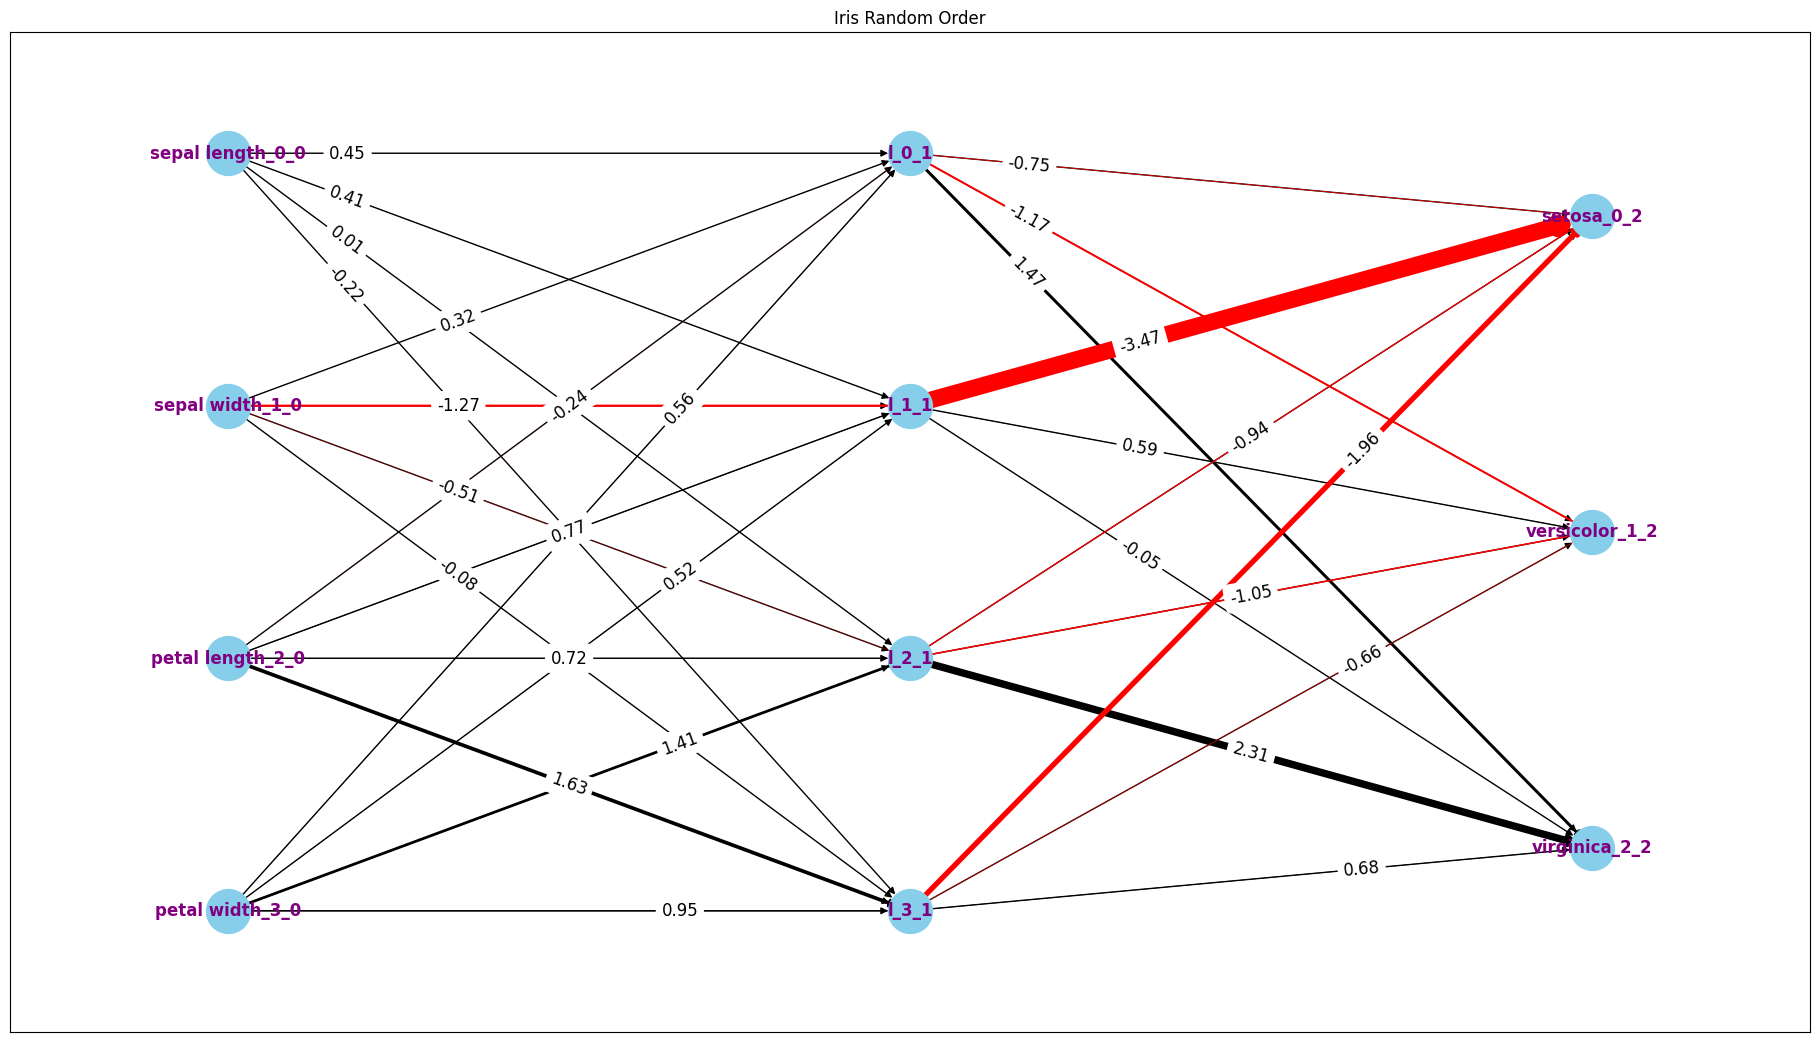

In [31]:
#alpha is based on weight

edge_colors = []
alpha = []
width = [] #width is defined here
for u, v, d in G.edges(data=True):
    if d['weight'] > 0:
        edge_colors.append('black')
    else:
        edge_colors.append('red')
    alpha.append(d['weight'])
    width.append(d['weight'] ** 2) #thickness squared here


plt.figure(figsize=(18, 10))

#handles: nodes, node size, node color,
nx.draw(G, pos=pos, node_size=1000, node_color='skyblue', arrows=True)

#handles edges, edge thickness, and edge color
nx.draw_networkx_edges(G, pos=pos, edge_color=edge_colors, arrows=True, width = width)

# key = edge and val = weight
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
# handles edge labels pos
for u, v in G.edges():
    specific_edge_labels = {(u, v): edge_labels[(u, v)]}
    row = int(u.split('_')[1])
    index = int(u.split('_')[2])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=specific_edge_labels, font_color='black', font_size=12, label_pos = (row + 1) / (colSize[index]+2))

#handles node labels
nx.draw_networkx_labels(G, pos, font_size=12, font_color='purple', font_weight='bold')

plt.title('Iris Random Order')

plt.axis('on')
plt.margins(0.1)

plt.show()

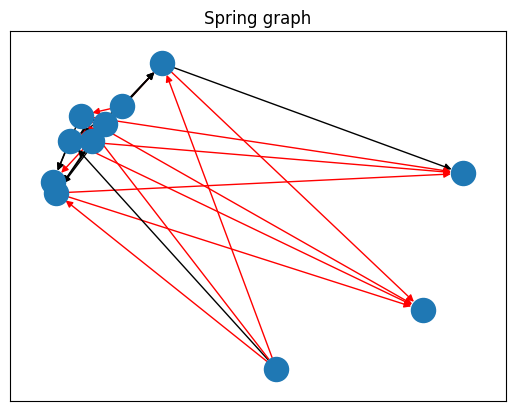

In [32]:
springPos = nx.spring_layout(G, weight = 'weight', k = 1, iterations = 500)
nx.draw_networkx_edges(G, pos = springPos, edge_color = edge_colors);
nx.draw_networkx_nodes(G, pos = springPos);
nx.draw_networkx_labels(G, pos, font_size=8, font_color='purple', font_weight='bold')
plt.title("Spring graph");

In [33]:
#puts the spring coordinates into a dataframe
springPos = pd.Series(springPos)
xVals, yVals = zip(*springPos)
coordsS = pd.DataFrame({
    'xVals' : xVals,
    'yVals' : yVals
})

#associates the coords with their nodes
coordsS.index = list(G.nodes())

#combines the x and y coordinates into 1 values
pca = PCA(n_components=1)
y_pca = pca.fit_transform(coordsS)
coordsS = pd.DataFrame({
    'coords' : y_pca.flatten()
    })

#associates the coords with their nodes
coordsS.index = list(G.nodes())
#associates each node and y-val with a column
coordsS['column'] = coordsS.apply(lambda x: x.name.split('_')[2], axis = 1)

# sorts the nodes by columns and then pca values
sorted_groups = coordsS.groupby('column', group_keys=False).apply(lambda x: x.sort_values('coords'))
sorted_groups['group_index'] = sorted_groups.groupby('column').cumcount() #makes sorted values as group index

NN dynamic layout graph based on Spring

In [34]:
weights = model.weights
# Create a directed graph
G = nx.DiGraph()

pos = {}
maxRow = sorted_groups['group_index'].max() + 2
col    = 0
i      = 0
while i < len(weights):
  w = weights[i] #w are weights associated with a col
  for sourceRow in range(w.shape[0]):
    if col == 0: #if node is in the first layer, it makes the name the input val
      source_node = ind_input_names[sourceRow] + '_' + str(sourceRow) + '_' + str(col)
    else:
      source_node = 'l_' + str(sourceRow) + '_' + str(col)

    if source_node not in pos.keys():
      sourceColumn = sorted_groups.loc[source_node]['column']
      colLength = (int(sorted_groups[sorted_groups['column'] \
        == sourceColumn]['group_index'].max()) + 2)
      currRow = (sourceRow + 1)

      pos[source_node] = (col, maxRow/colLength * currRow)

    for row in range(w.shape[1]):
      if (col + 1) == len(weights)//2: # makes last layer node names = the output values
        dest_node = ind_output_names[row] + '_' + str(row) + '_' + str(col + 1)
      else:
        dest_node = 'l_' + str(row) + '_' + str(col+1)

      G.add_edge(source_node, dest_node, weight = w[sourceRow][row])
      if dest_node not in pos.keys(): #gives pos if needed
        destColumn = sorted_groups.loc[dest_node]['column']
        colLength = (int(sorted_groups[sorted_groups['column'] \
          == destColumn]['group_index'].max()) + 2)
        currRow = sorted_groups.loc[dest_node]['group_index'] + 1

        pos[dest_node] = (col + 1, maxRow/colLength * currRow)

  i += 2
  col += 1

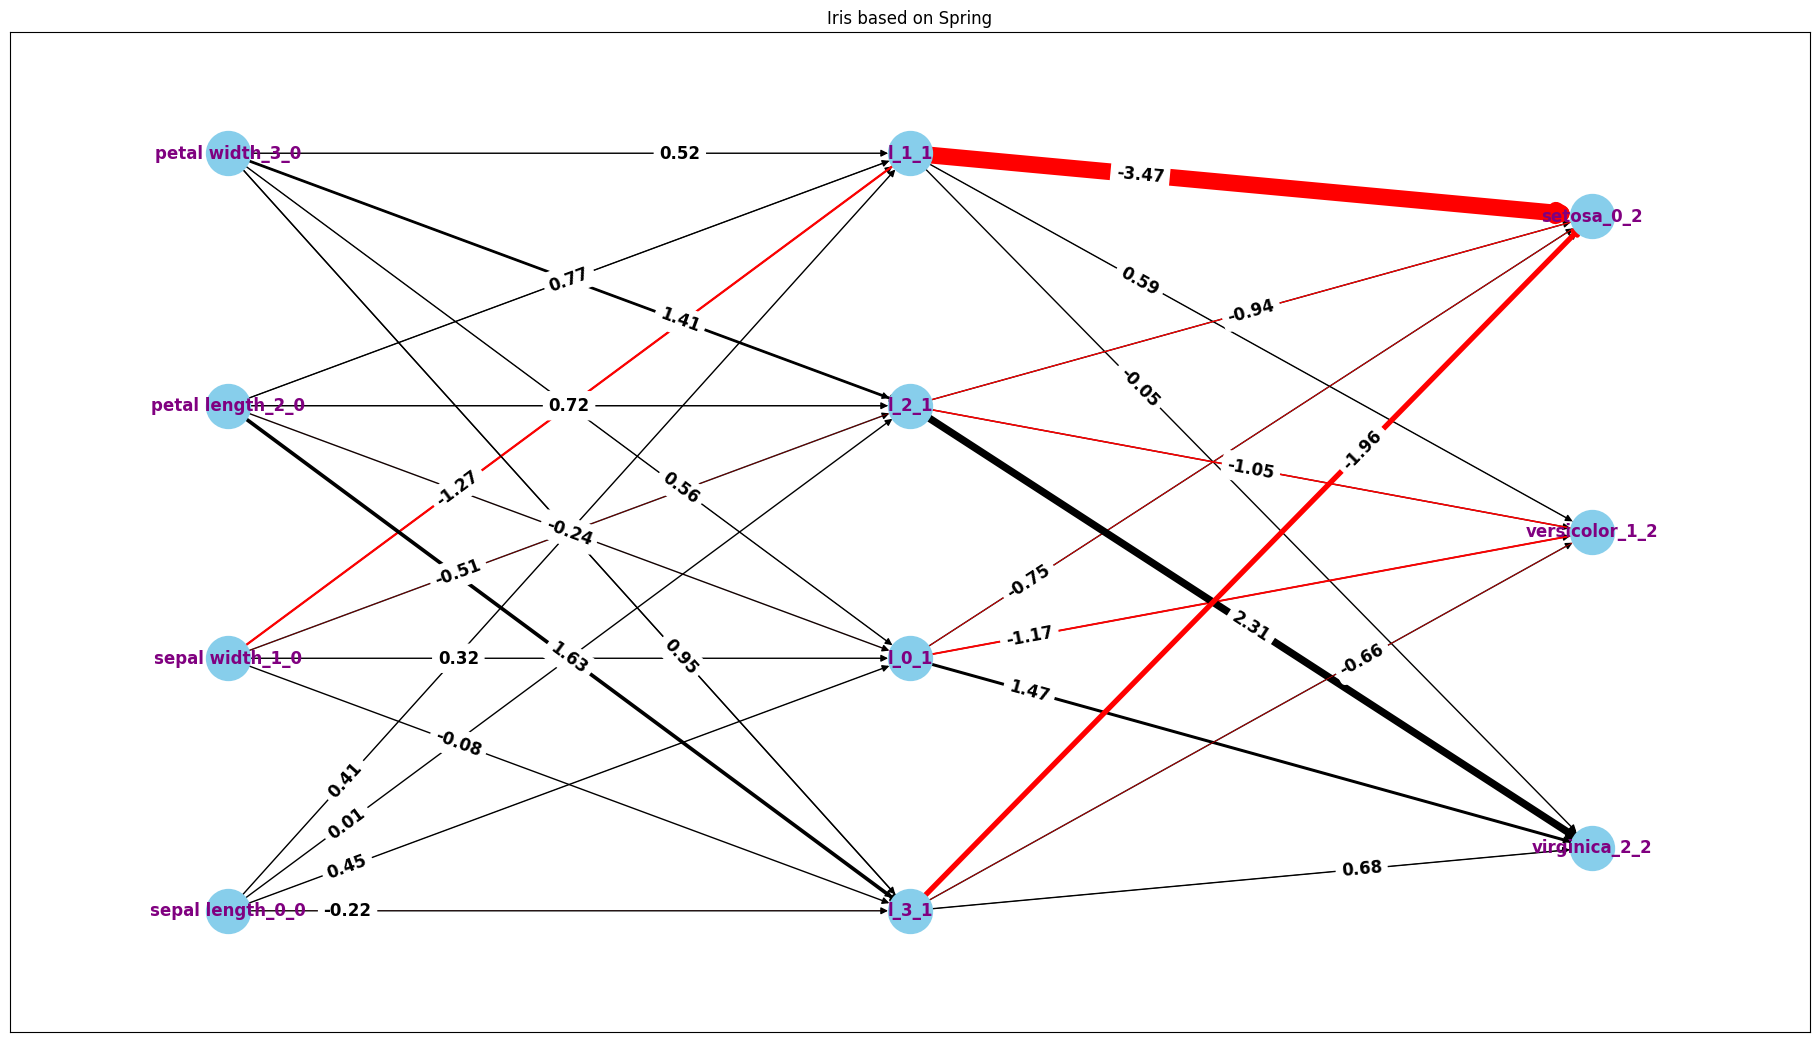

In [35]:
plt.figure(figsize=(18, 10))

#nodes, nodes size, and node color
nx.draw(G, pos=pos, node_size=1000, node_color='skyblue', arrows=True)

#edges, edge color, and edge width
nx.draw_networkx_edges(G, pos=pos, edge_color=edge_colors, arrows=True, width = width)


edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
# edge labels and their positioning
for u, v in G.edges():
    specific_edge_labels = {(u, v): edge_labels[(u, v)]}
    row = int(u.split('_')[1])
    index = int(u.split('_')[2])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=specific_edge_labels, font_color='black', font_weight = 'bold', font_size=12, label_pos = (row + 1) / (colSize[index]+2))

#node names
nx.draw_networkx_labels(G, pos, font_size=12, font_color='purple', font_weight='bold')

plt.title('Iris based on Spring')

plt.axis('on')
plt.margins(0.1)

plt.show()

### FDEB

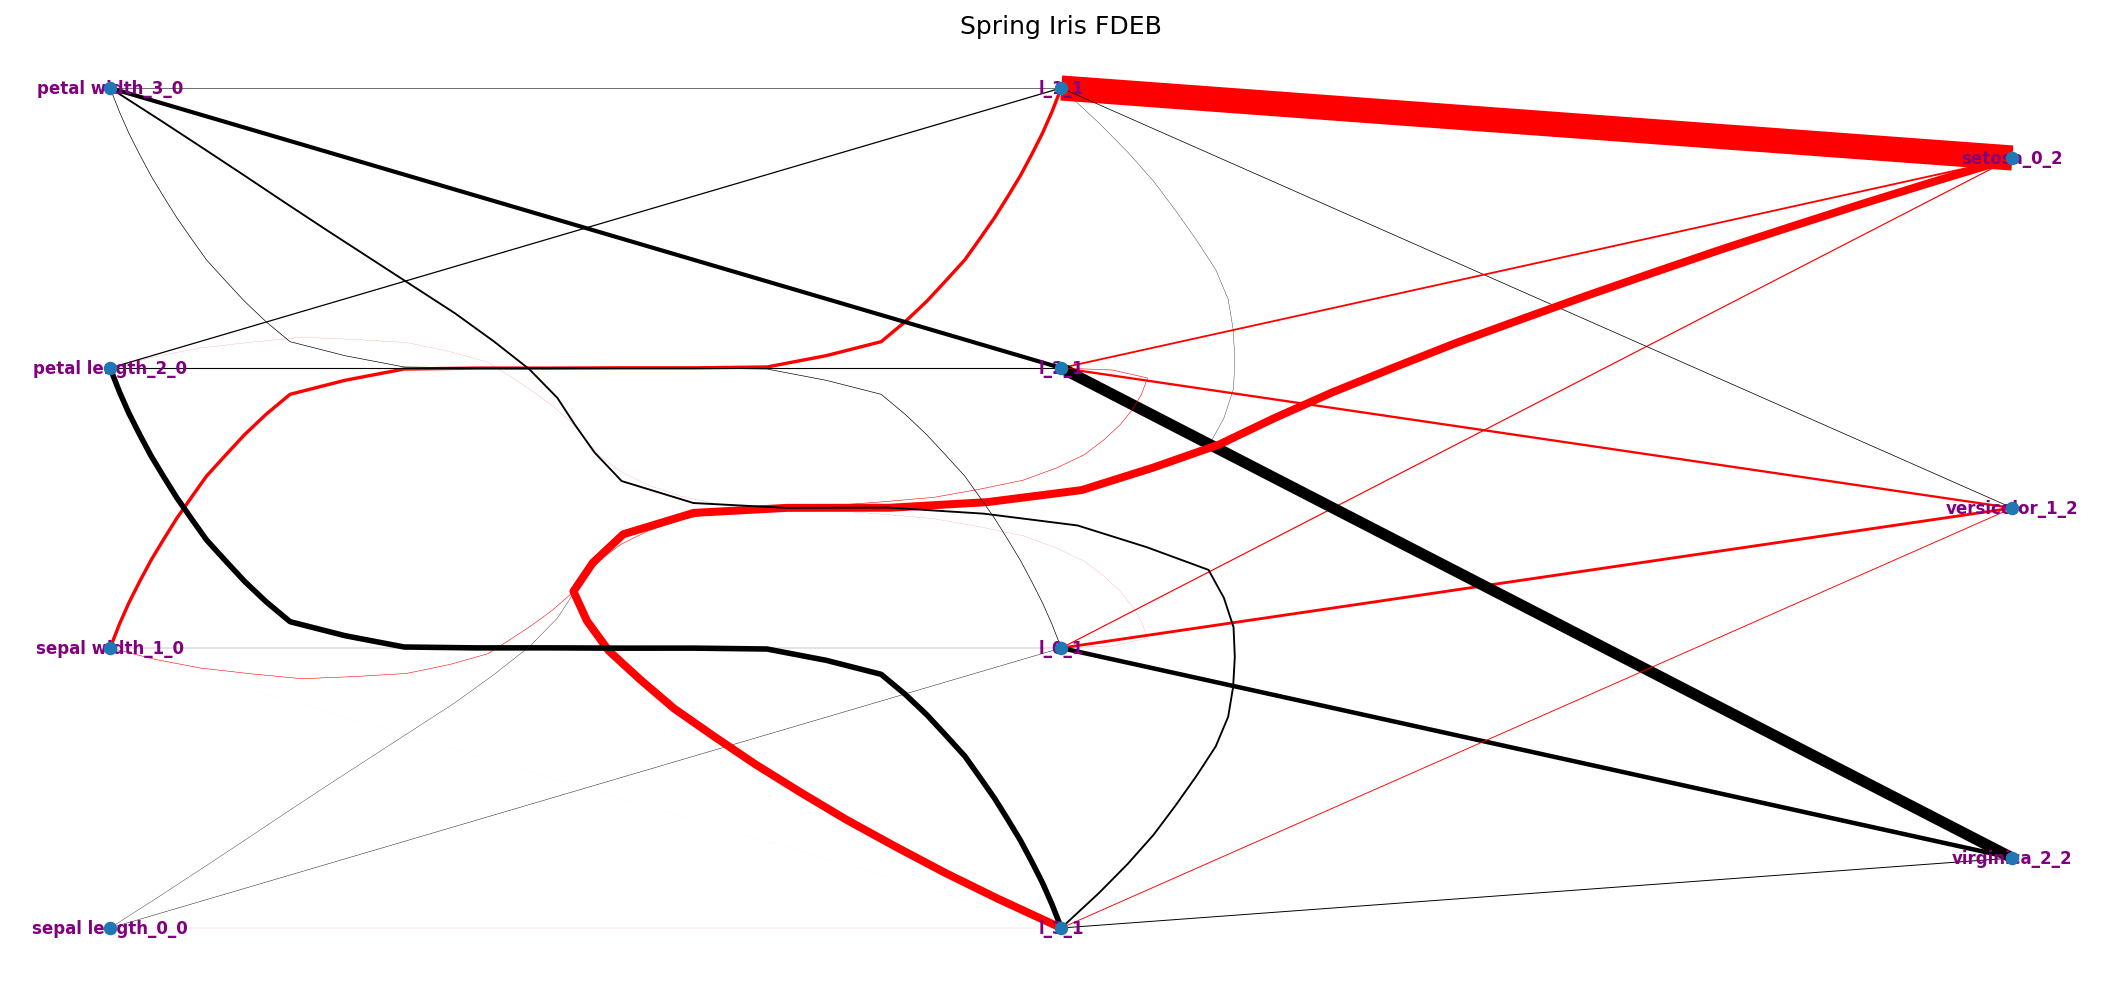

In [36]:
x = np.array(list(pos.values())) # gets the positions
adj = nx.to_scipy_sparse_array(G).tocoo() #makes adjacency matrix
weights = adj.data #gets the weigths

# Extract edges from embedding and adjacency matrix
edges = np.stack([x[adj.row], x[adj.col]], axis=1)

# Compute FDEB
edges_fdeb = fdeb(edges) #bundles edges

fig, ax = plt.subplots(figsize=(18, 8), dpi=150)

# Gets correct colors and line widths
for edge, weight in zip(edges_fdeb, weights):
    if weight >= 0:
      line = collections.LineCollection([edge], color="black", linewidth=weight ** 2 , alpha=1)
    else:
      line = collections.LineCollection([edge], color="red", linewidth=weight ** 2, alpha=1)
    ax.add_collection(line)

#node names
nx.draw_networkx_labels(G, pos, font_size=8, font_color='purple', font_weight='bold')


# Plot nodes
ax.scatter(x[:, 0], x[:, 1], c="tab:blue", s=30, zorder=3)


plt.title('Spring Iris FDEB')

# Hide axes
ax.axis('off')

plt.show()

### ChatGPTs attempt at making FDEB useful

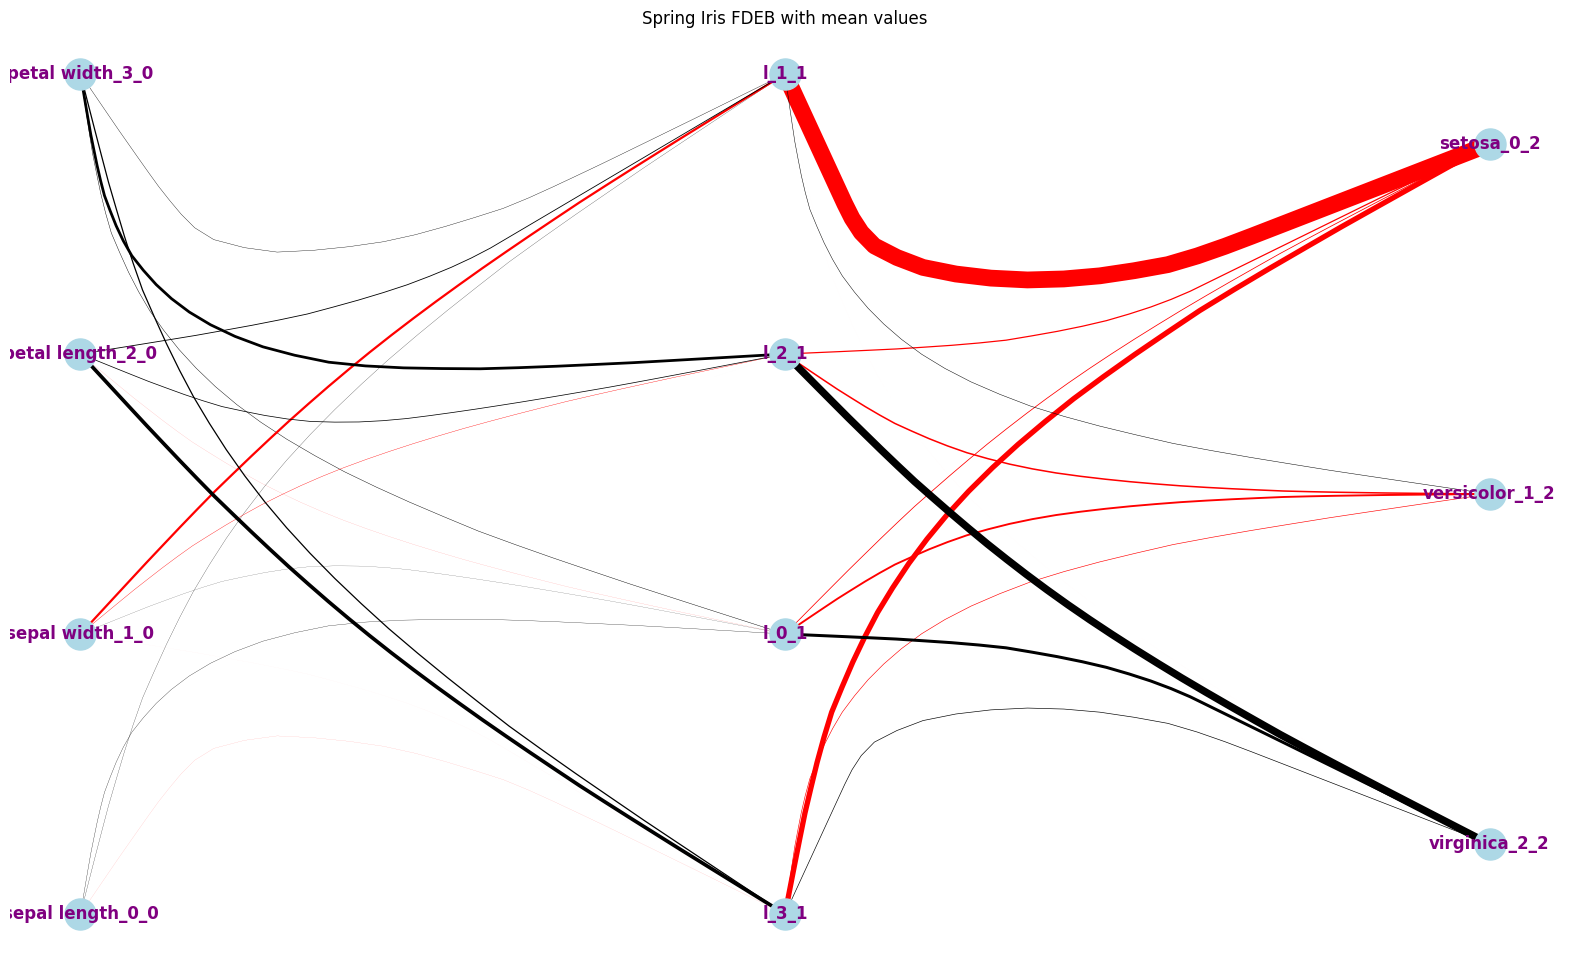

In [37]:
# Function to preprocess edges for edge bundling
# essentially, it trys to add a point in the middle of the edges, which will
# cause for better attraction, it was also trying (and failing) to factor in weights
def preprocess_edges(edges, node_positions):
    bundled_edges = []
    bundled_weights = []
    for target_node in G.nodes():
        incoming_edges = [edge for edge in edges if edge[1] == target_node] #gets edges that share the dest/target node
        if len(incoming_edges) <= 1:
            continue

        mean_position = np.mean([pos[edge[0]] for edge in incoming_edges], axis=0) # averages the positions of the source nodes

        # Move control points towards the mean position
        for edge in incoming_edges:
            source = pos[edge[0]]
            target = pos[edge[1]]
            control_points = [source, mean_position, target]
            bundled_edges.append(control_points) # attempts to use those three points in the FDEB along with the weights
            bundled_weights.append(G[edge[0]][edge[1]]['weight'])  # makes an array of the weights

    return np.array(bundled_edges), np.array(bundled_weights)

# Preprocess edges for bundling
edges = list(G.edges())
bundled_edges, bundled_weights = preprocess_edges(edges, pos)

# Perform edge bundling with FDEB
edges_fdeb = fdeb(bundled_edges) #, bundled_weights) #took this off because the linear algebra math wasn't mathing, probably fixable tbh

plt.figure(figsize=(20, 12))

# adds edge colors and thickness
for edge, weight in zip(edges_fdeb, bundled_weights):
    if weight>=0:
      line = collections.LineCollection([edge], color='black', linewidth=weight ** 2)
    else:
      line = collections.LineCollection([edge], color='red', linewidth=weight ** 2)
    plt.gca().add_collection(line)

# nodes, node color, and node size
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')

# node names
nx.draw_networkx_labels(G, pos, font_size=12, font_color='purple', font_weight='bold')

plt.title('Spring Iris FDEB with mean values')
plt.axis('off')
plt.show()


### NetGraph attempt at bundling

In [38]:
# node_to_community = {}
# for node in G.nodes():
#   node_to_community[node] = int(node.split('_')[2])

In [39]:
# #adds node color based on community
# community_to_color = {
#     0 : 'tab:blue',
#     1 : 'tab:orange',
#     2 : 'tab:green',
#     3 : 'tab:red',
# }
# node_color = {node: community_to_color[community_id] \
#               for node, community_id in node_to_community.items()}

In [40]:
# # A dictionary where key = edge and val = np.array(weight)
# width = {edge: np.array(G[edge[0]][edge[1]]['weight']).item() for edge in G.edges()}

# edge_colors = {edge: 'black' if np.array(G[edge[0]][edge[1]]['weight']).item() >= 0 else 'red' for edge in G.edges()}

# edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}

# pos2 = {} # Makes a dictionary where key = node and val = np.array(x, y)
# for node, val in pos.items():
#   pos2[node]= np.array([val[0], val[1]])

# # Use the edge_layout option to bundle the edges together
# fig, ax = plt.subplots(figsize = (30, 50))
# Gbundle = Graph(G,
#       node_color=node_color,
#       # node_size = 10,
#       edge_width = width,
#       edge_color = edge_colors,
#       node_layout=pos2,
#       edge_labels = edge_labels,
#       # node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
#       edge_layout='bundled', # this is where bundling is made possible,
#       node_labels = True,
#       edge_alpha = 1,
#       ax=ax,
# )
# # Gbundle.node_positions =
# plt.show()


### Midpoints

In [41]:
#create midpoints between columns with white nodes. the y val of the midpt is based on the output node

weights = model.weights
# Create a Multi Drected graph
G = nx.MultiDiGraph()

pos = {}
col = 0
mdpt_weights = {}

i = 0
while i < len(weights): #gets weights associated with the a column
  w = weights[i] #ws are weights between two layers

  for sourceRow in range(w.shape[0]):
    if col == 0: # makes the first layer of nodes' names input the variables
      # rows and columns are kept in the name to help with determining pos
      source_node = ind_input_names[sourceRow] + '_' + str(sourceRow) + '_' + str(col)
    else:
      source_node = 'l_' + str(sourceRow) + '_' + str(col)

    if source_node not in pos.keys():
      sourceColumn = sorted_groups.loc[source_node]['column']
      colLength = (int(sorted_groups[sorted_groups['column'] \
        == sourceColumn]['group_index'].max()) + 2)
      currRow = (sourceRow + 1)

      pos[source_node] = (col, maxRow/colLength * currRow * 5)

    for row in range(w.shape[1]): #w.shape[1] is number of rows in next column

      midpt = 'mp_' + str(row) + '_' + str(col + 1)
      if not G.has_edge(source_node, midpt): #neccessary as this is a multigraph
        G.add_edge(source_node, midpt, weight = np.array(w[sourceRow][row]).item())

      if col+1 == len(weights)//2: #if last layer, makes node names the output variables
        dest_node = ind_output_names[row] + '_' + str(row) + '_' + str(col + 1)
      else:
        dest_node = 'l_' + str(row) + '_' + str(col + 1)

      if dest_node not in pos.keys():
        destColumn = sorted_groups.loc[dest_node]['column']
        colLength = (int(sorted_groups[sorted_groups['column'] \
          == destColumn]['group_index'].max()) + 2)
        currRow = sorted_groups.loc[dest_node]['group_index'] + 1
        pos[dest_node] = (col + 1, (maxRow/colLength * currRow) * 5)

      if midpt not in pos.keys():
        pos[midpt] = (col + .5, maxRow/colLength * currRow * 5)

      #adds up the total pos and neg weights from mdpt to dest nodes
      edge_weight = np.array(w[sourceRow][row]).item()
      mdpt_weights.setdefault(midpt, (0, 0)) # dictionary: keys = midpt nodes, vals = coords

      positive_weight = mdpt_weights[midpt][0]
      negative_weight = mdpt_weights[midpt][1]

      if edge_weight >= 0:
        positive_weight += edge_weight
      else:
        negative_weight += edge_weight

      mdpt_weights[midpt] = (positive_weight, negative_weight)

  i += 2
  col += 1

for key, val in mdpt_weights.items():
  #renames last layer to be output names
  if int(key.split('_')[2]) == len(weights)//2:
    dest_node = ind_output_names[int(key.split('_')[1])] + '_' + key.split('_')[1] + '_' + key.split('_')[2]
  else:
    dest_node = 'l_' + key.split('_')[1] + '_' + key.split('_')[2]

  # makes the two edges (pos and neg) btwn mdpt and actual layers, if either pos or neg or 0 doens't do it
  if val[0] != 0:
    G.add_edge(key, dest_node, weight = float(val[0])) # positive weight
  if val[1] != 0:
    G.add_edge(key, dest_node, weight = float(val[1])) # negative weight

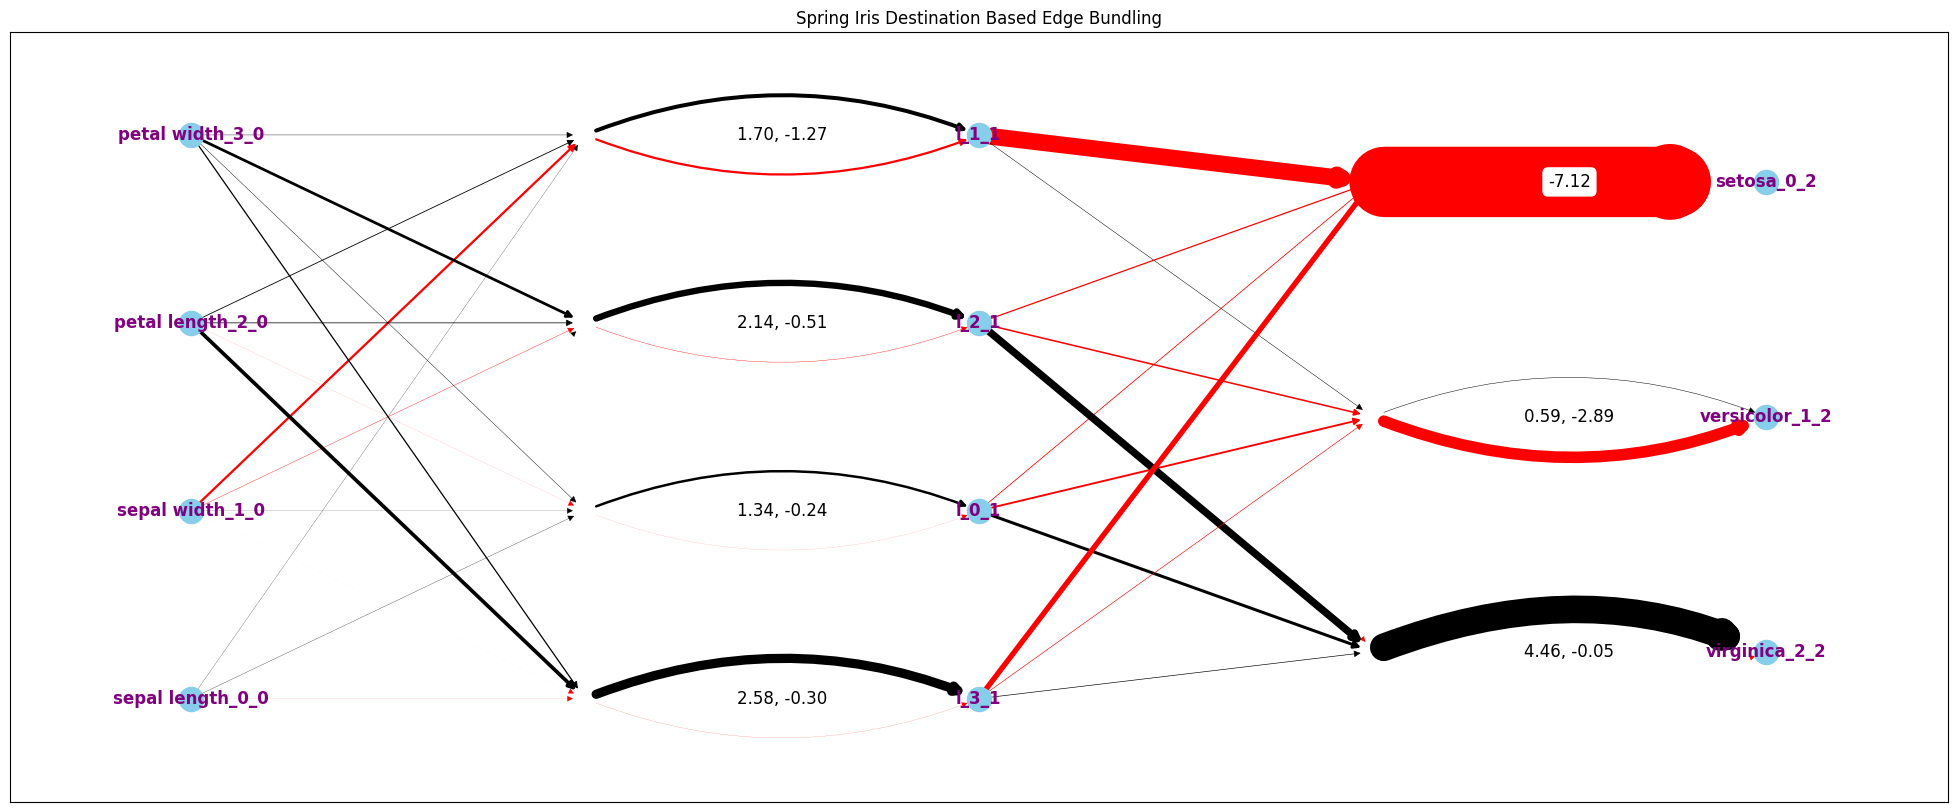

In [46]:
edge_colors = ['black' if G[u][v][key]['weight'] >= 0 else 'red' for u, v, key in G.edges(keys=True)] # Edge colors based on weight
width = [G[u][v][key]['weight'] ** 2 for u, v, key in G.edges(keys=True)] # Edge width based on weight
node_list = [node for node in G.nodes() if node[:2] != 'mp']
connectionStyle = []


for u, v, key in G.edges(keys=True):
  if u.split('_')[0] != 'mp': #if source node isn't a mdpt, edge is straight
    connectionStyle.append('arc3')
  else:
    try: # if both a pos and neg edge exist btwn midpt and dest then, pos curves up, and neg curces down
      if G[u][v][0]['weight'] != 0 and G[u][v][1]['weight'] != 0:
        if key == 0:
          connectionStyle.append(f'arc3,rad={-0.20}')
        else:
          connectionStyle.append(f'arc3,rad={0.20}')
    except KeyError as e: # if only a positive or negative edge btwn mdpt and dest, then edge is straight
      connectionStyle.append('arc3')

plt.figure(figsize=(25, 10))

#draws none mdpt nodes, with color and size
nx.draw_networkx_nodes(G, pos=pos, nodelist=node_list, node_size=300, node_color='skyblue')

label_pos = {} #makes pos for node labels, to prevent mdpt labeling
for node, coords in pos.items():
  if node.split('_')[0] != 'mp':
    label_pos[node] = np.array([coords[0], coords[1]]) # if not mp gives lable
  else:
    label_pos[node] = np.array([-55000, -550000]) # if mp throws the labels way out there because we don't want to see them

# node names
nx.draw_networkx_labels(G, label_pos, font_size=12, font_color='purple', font_weight='bold')



# Draw edges individually with specified connection styles (adds a curve if more than two edges per two nodes)
for (u, v, key), color, style, w in zip(G.edges(keys=True), edge_colors, connectionStyle, width):
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v, key)],
        edge_color=color,
        connectionstyle=style,
        width=w,
        arrows=True
    )

# edge labels
edge_labels = {}
for u, v, key in G.edges(keys=True):
  if u.split('_')[0] != 'mp': # if not source node isn't a mp then just give typical weights
    edge_labels[(u, v, key)] = f"{G[u][v][key]['weight']:.2f}"
  else:
    try:
      if G[u][v][0]['weight'] != 0 and G[u][v][1]['weight'] != 0:
        # if both outgoing weights of positive and negative give Positive, negative
        edge_labels[(u, v, key)] = f"{G[u][v][0]['weight']:.2f}, {G[u][v][1]['weight']:.2f}"
    except KeyError as e:
      #if only one key give a singular weight
      edge_labels[(u, v, key)] = f"{G[u][v][key]['weight']:.2f}"

# draws the edge labels
for u, v, key in G.edges(keys=True):
    specific_edge_labels = {(u, v, key): edge_labels[(u, v, key)]}
    row = int(u.split('_')[1])
    index = int(u.split('_')[2])
    if u[:2] == 'mp':
      nx.draw_networkx_edge_labels(G, pos, edge_labels=specific_edge_labels, font_color='black', font_size=12, label_pos = 0.5)
#    else:
#       nx.draw_networkx_edge_labels(G, pos, edge_labels=specific_edge_labels, font_color='black', font_size=12, label_pos = (row + 1) / (colSize[index]+2))




plt.title('Spring Iris Destination Based Edge Bundling')
plt.axis('on')
plt.margins(0.1)
plt.show()
